In [1]:
pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## Reading Dataset 

In [4]:
url='https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/FTSEfundamental.csv'
df1 = pd.read_csv(url, parse_dates= True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

macro_data=df1.copy()
macro_data=macro_data.asfreq('b')
macro_data=macro_data.fillna(method='ffill')
macro_data['returns'] = macro_data.ftseclose.pct_change(1).mul(100)
macro_data = macro_data.iloc[1:]
macro_data=macro_data[macro_data.index < '2020-12-01']

In [5]:
macro_data.head()

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
Date,,,,,,,,,,,
1994-04-01,3086.399902,3086.399902,3086.399902,3086.399902,0.0,1.4757,7.5876,1.2,9.8,6.8512,0.000000
1994-04-04,3086.399902,3086.399902,3086.399902,3086.399902,0.0,1.4757,7.5876,1.2,9.8,6.8512,0.000000
1994-04-05,3060.899902,3116.199951,3047.000000,3116.199951,0.0,1.4757,7.5876,1.2,9.8,6.8512,0.965528
1994-04-06,3142.800049,3145.399902,3129.600098,3131.500000,0.0,1.4757,7.5876,1.2,9.8,6.8512,0.490984
1994-04-07,3133.399902,3143.500000,3117.000000,3129.000000,0.0,1.4757,7.5876,1.2,9.8,6.8512,-0.079834


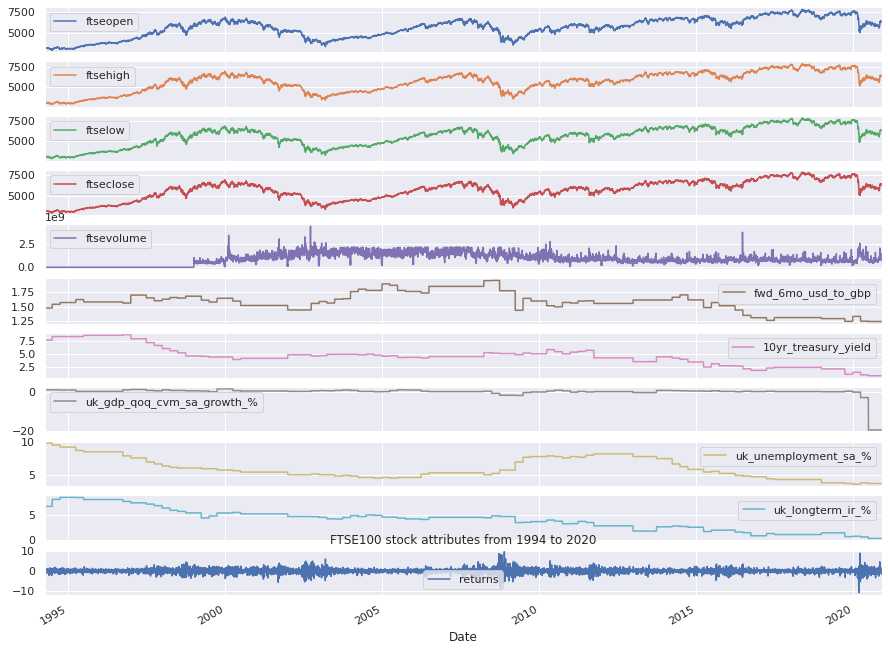

In [7]:
macro_data['1994':'2020'].plot(subplots=True, figsize=(15,12))
plt.title('FTSE100 stock attributes from 1994 to 2020')
plt.savefig('stocks.png')
plt.show()

In [8]:
macro_data.columns

Index(['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%', 'returns'],
      dtype='object')

[10:38:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


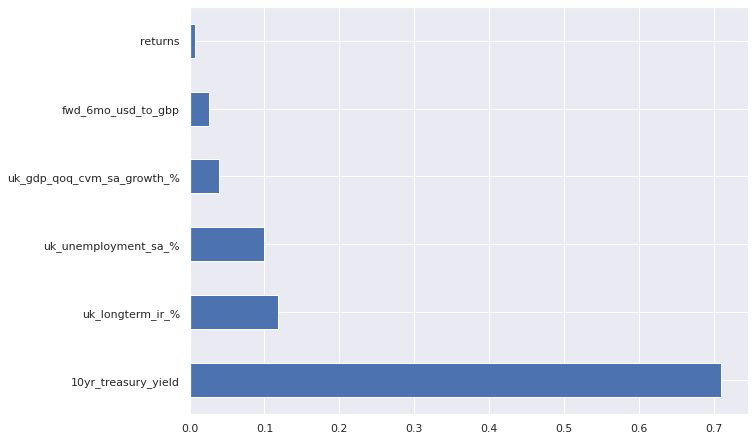

In [9]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(macro_data[[ 'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']], macro_data[['ftseclose']])

(pd.Series(model.feature_importances_, index=macro_data[['fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']].columns)
   .nlargest(7)
   .plot(kind='barh'))

In [10]:
macro_data.isnull().sum()

ftseopen                      0
ftsehigh                      0
ftselow                       0
ftseclose                     0
ftsevolume                    0
fwd_6mo_usd_to_gbp            0
10yr_treasury_yield           0
uk_gdp_qoq_cvm_sa_growth_%    0
uk_unemployment_sa_%          0
uk_longterm_ir_%              0
returns                       0
dtype: int64

In [11]:
macro_data.describe()

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
count,6957.000000,6957.000000,6957.000000,6957.000000,6.957000e+03,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000
mean,5604.860830,5641.858130,5567.030705,5605.429624,8.900640e+08,1.580548,4.541826,0.133477,6.089334,4.131159,0.016606
std,1187.289850,1191.331880,1183.381080,1187.116549,6.034058e+08,0.173451,1.824572,2.564365,1.538291,2.179830,1.132864
min,2844.699951,2902.199951,2844.699951,2876.600098,0.000000e+00,1.237400,0.834700,-19.500000,3.700000,0.303333,-10.873819
25%,4755.500000,4791.100098,4722.799805,4755.799805,5.589860e+08,1.513700,3.507200,0.300000,4.900000,2.586967,-0.510718
50%,5826.700195,5866.600098,5778.399902,5827.799805,8.269085e+08,1.582100,4.465500,0.400000,5.500000,4.458034,0.009108
75%,6465.700195,6511.100098,6423.799805,6466.200195,1.306519e+09,1.665000,5.035700,0.700000,7.700000,5.311433,0.571926
max,7877.500000,7903.500000,7854.600098,7877.500000,4.420947e+09,1.962400,8.627300,1.700000,9.800000,8.693767,9.838667


In [12]:
print('ftseclose causes 10yr_treasury_yield\n')
granger_1 = grangercausalitytests(macro_data[['ftseclose', '10yr_treasury_yield']].diff()[1:], [5])
print('------------------')

print('10yr_treasury_yield causes ftseclose\n')
granger_1 = grangercausalitytests(macro_data[[ '10yr_treasury_yield','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftseclose causes uk_unemployment_sa_%\n')
granger_2 = grangercausalitytests(macro_data[['ftseclose', 'uk_unemployment_sa_%']].diff()[1:], [5])
print('------------------')

print('uk_unemployment_sa_% causes ftseclose \n')
granger_2 = grangercausalitytests(macro_data[['uk_unemployment_sa_%','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftseclose causes fwd_6mo_usd_to_gbp?\n')
granger_2 = grangercausalitytests(macro_data[['ftseclose', 'fwd_6mo_usd_to_gbp']].diff()[1:], [5])
print('------------------')

print(' fwd_6mo_usd_to_gbp  causes ftseclose\n')
granger_2 = grangercausalitytests(macro_data[[ 'fwd_6mo_usd_to_gbp','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftseclose causes uk_gdp_qoq_cvm_sa_growth_%	\n')
granger_2 = grangercausalitytests(macro_data[['ftseclose', 'uk_gdp_qoq_cvm_sa_growth_%']].diff()[1:], [5])
print('------------------')

print(' uk_gdp_qoq_cvm_sa_growth_% causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['uk_gdp_qoq_cvm_sa_growth_%','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftsevolume causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['ftsevolume','ftseclose']].diff()[1:], [5])
print('------------------')

print('returns causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['returns','ftseclose']].diff()[1:], [5])
print('------------------')

print('uk_longterm_ir_% causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['uk_longterm_ir_%','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftselow causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['ftselow','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftsehigh causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['ftsehigh','ftseclose']].diff()[1:], [5])
print('------------------')

print('ftseopen causes ftseclose	\n')
granger_2 = grangercausalitytests(macro_data[['ftseopen','ftseclose']].diff()[1:], [5])
print('------------------')

ftseclose causes 10yr_treasury_yield


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.7734  , p=0.0021  , df_denom=6940, df_num=5
ssr based chi2 test:   chi2=18.8969 , p=0.0020  , df=5
likelihood ratio test: chi2=18.8713 , p=0.0020  , df=5
parameter F test:         F=3.7734  , p=0.0021  , df_denom=6940, df_num=5
------------------
10yr_treasury_yield causes ftseclose


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1320  , p=0.3408  , df_denom=6940, df_num=5
ssr based chi2 test:   chi2=5.6688  , p=0.3398  , df=5
likelihood ratio test: chi2=5.6665  , p=0.3400  , df=5
parameter F test:         F=1.1320  , p=0.3408  , df_denom=6940, df_num=5
------------------
ftseclose causes uk_unemployment_sa_%


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3068  , p=0.0419  , df_denom=6940, df_num=5
ssr based chi2 test:   chi2=11.5524 , p=0.0415  , df=5
likelihood ratio test: chi2=11.5428 , p=0.0416  , df=5
parameter

# VARMA

In [13]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding MSE
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        mse = model.mse
        results.append([param, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
endog = macro_data[['ftseclose','uk_gdp_qoq_cvm_sa_growth_%','returns','uk_unemployment_sa_%','10yr_treasury_yield','uk_longterm_ir_%']]

In [ ]:
endog = macro_data[['ftseclose','uk_gdp_qoq_cvm_sa_growth_%','returns','uk_unemployment_sa_%','10yr_treasury_yield','uk_longterm_ir_%']]

p = range(0, 5, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)
result_df_VARMA

,"(p,q)",mse
0,"(4, 3)",4592.949061
1,"(4, 2)",4593.173308
2,"(4, 1)",4593.201471
3,"(4, 0)",4593.266572
4,"(2, 3)",4593.454474
5,"(1, 3)",4593.559225
6,"(3, 3)",4594.181051
7,"(3, 2)",4600.220916
8,"(3, 1)",4600.240327
9,"(3, 0)",4600.398320


In [15]:
best_model_VARMA = VARMAX(endog, order=(4,3))
res_VARMA = best_model_VARMA.fit(disp=False)
print(res_VARMA.summary())

                                                                               Statespace Model Results                                                                              
Dep. Variable:     ['ftseclose', 'uk_gdp_qoq_cvm_sa_growth_%', 'returns', 'uk_unemployment_sa_%', '10yr_treasury_yield', 'uk_longterm_ir_%']   No. Observations:                 6957
Model:                                                                                                                            VARMA(4,3)   Log Likelihood                2823.204
                                                                                                                                 + intercept   AIC                          -5088.408
Date:                                                                                                                       Tue, 27 Jul 2021   BIC                          -3177.954
Time:                                                                                     

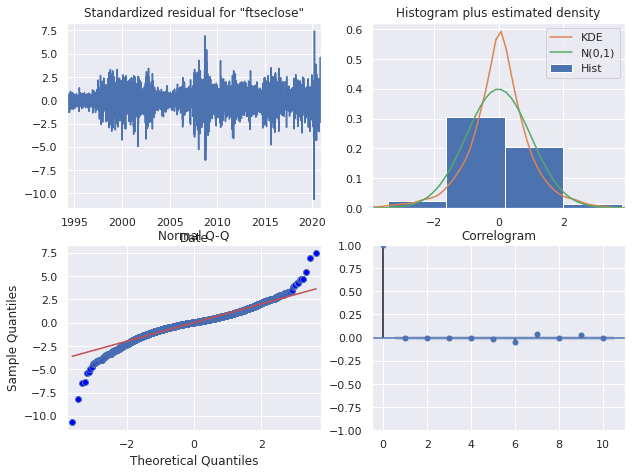

In [16]:
res_VARMA.plot_diagnostics();

In [17]:
n_forecast = 30
predict = res_VARMA.get_prediction(end=best_model_VARMA.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

In [ ]:
macro_date_show = macro_data[macro_data.index >= '2020-11-01']
true_vals = df1[(df1.index >= '2020-12-01') & (df1.index < '2021-01-01')]

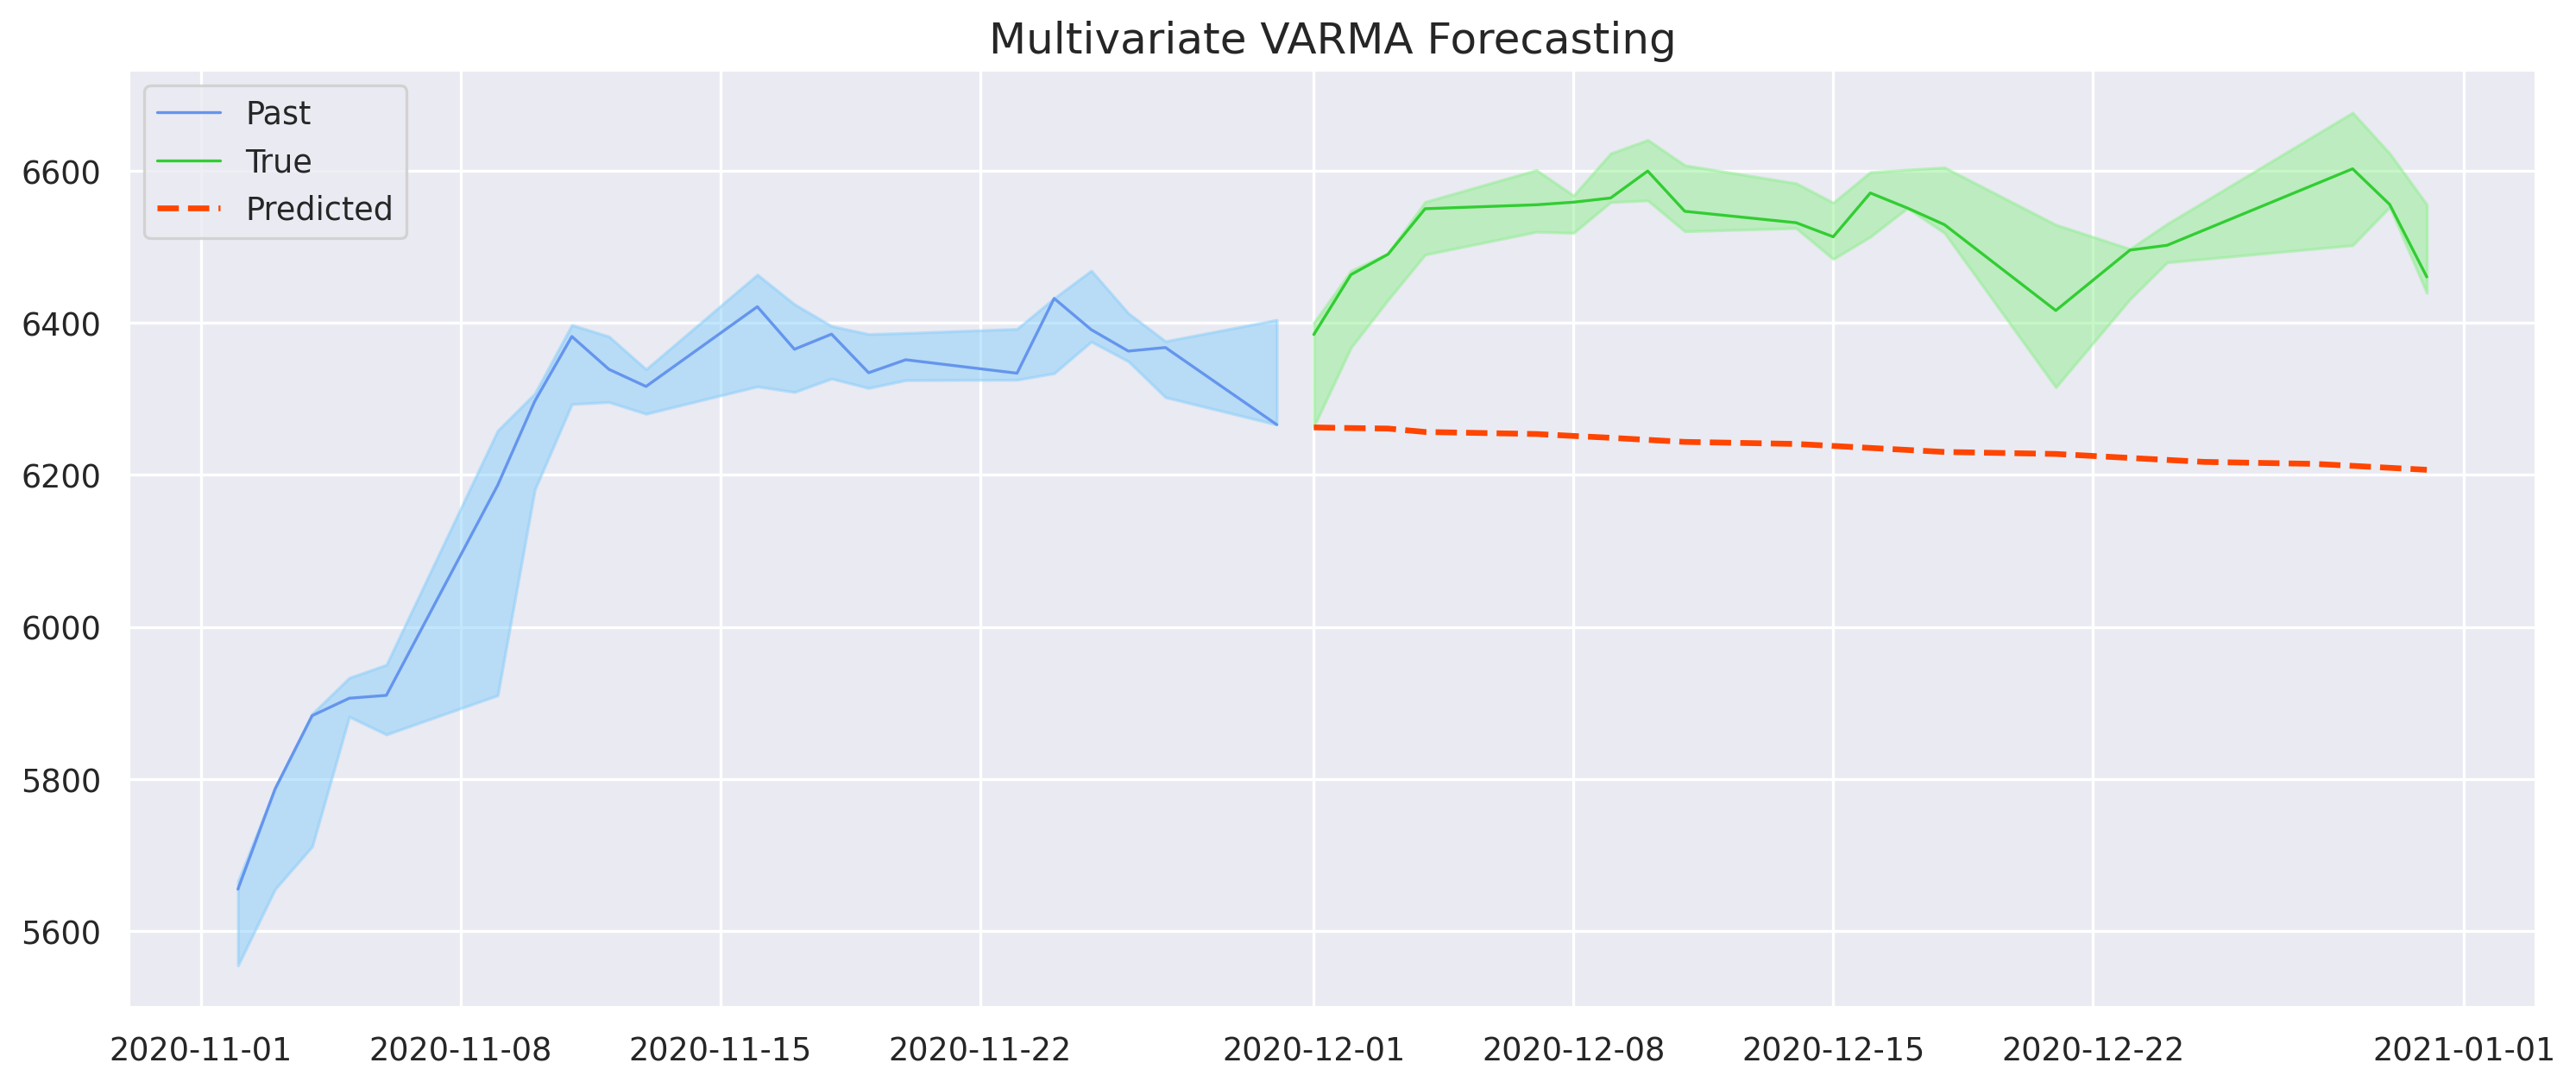

In [ ]:
fig, ax1 = plt.subplots(dpi=240,figsize=(15,6))

ax1.plot(macro_date_show['ftseclose'], color='cornflowerblue', linewidth=1, label='Past')
ax1.plot(true_vals['ftseclose'], color='limegreen', linewidth=1, label='True')


ax1.plot(predict.predicted_mean.index[-31:-8], 
         predict.predicted_mean['ftseclose'][-31:-8], 
         color='orangered', 
         ls='--',
         linewidth=2, label='Predicted')

ax1.fill_between(macro_date_show.index, macro_date_show.ftselow, macro_date_show.ftsehigh, color='lightskyblue', alpha=0.5)
ax1.fill_between(true_vals.index, true_vals.ftselow, true_vals.ftsehigh, color='lightgreen', alpha=0.5)

ax1.set_title("Multivariate VARMA Forecasting", size = 15)
ax1.legend()

plt.show()

In [19]:
test_df = true_vals.resample('D').mean()[['ftseclose']]
test_df['preds'] = predict.predicted_mean[['ftseclose']][-31:-8].resample('D').mean().values

test_df = test_df.dropna()

NameError: ignored

In [20]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [21]:
timeseries_evaluation_metrics_func(test_df.ftseclose, test_df.preds)

NameError: ignored